In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_context("paper")

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# 🔥Competition 🏆 House Price Prediction🏡

This notebooks builds models for Kaggles [Houses Prices 🏡 competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). The objective is to develop a model which predicts the `SalePrice` of a a house. The submission evaluation metric is the _Root Mean Squared Error_ ([RMSE](https://en.wikipedia.org/wiki/Root_mean_square_deviation)) between the logarithm of the predicted value and the logarithm of the observed sales price. The format of the submission file `submission.csv` should be as follows: 
```
    Id,SalePrice
    1461,169000.1
    1462,187724.1233
    1463,175221
    etc.
```

In [2]:
houses = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
print(f"Rows: {houses.shape[0]:,}")
print(f"Cols: {houses.shape[1]:,}")
houses.head(3)

Rows: 1,460
Cols: 81


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
RANDOM_STATE = 42

# General Overview

In [4]:
dtype_groups = houses.columns.to_series().groupby(houses.dtypes).apply(list)

int_cols, float_cols, object_cols = [], [], []

for dtype, columns in dtype_groups.items():
    if dtype == 'int64': int_cols = columns
    elif dtype =='float64': float_cols = columns
    else: object_cols = columns
        
    print(f"There are {len(columns):3} columns of type {dtype}:")
    print(columns)
    print("\n")

There are  35 columns of type int64:
['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


There are   3 columns of type float64:
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


There are  43 columns of type object:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', '

In [5]:
print(houses.dtypes)

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object


In [6]:
features = int_cols + float_cols

In [7]:
temp = houses[features]

stats = pd.DataFrame({
    'Variable Name': temp.columns,
    'Missing Count': temp.isnull().sum().values,
    'Missing Rate (%)': 100*temp.isnull().mean().values,
    'Unique Count': temp.nunique().values,
    'Unique Rate (%)': 100*temp.nunique().values / len(temp)
}).sort_values(['Missing Rate (%)'], ascending=False)
stats

,Variable Name,Missing Count,Missing Rate (%),Unique Count,Unique Rate (%)
35,LotFrontage,259,17.739726,110,7.534247
37,GarageYrBlt,81,5.547945,97,6.643836
36,MasVnrArea,8,0.547945,327,22.397260
27,EnclosedPorch,0,0.000000,120,8.219178
21,TotRmsAbvGrd,0,0.000000,12,0.821918
22,Fireplaces,0,0.000000,4,0.273973
23,GarageCars,0,0.000000,5,0.342466
24,GarageArea,0,0.000000,441,30.205479
25,WoodDeckSF,0,0.000000,274,18.767123
26,OpenPorchSF,0,0.000000,202,13.835616


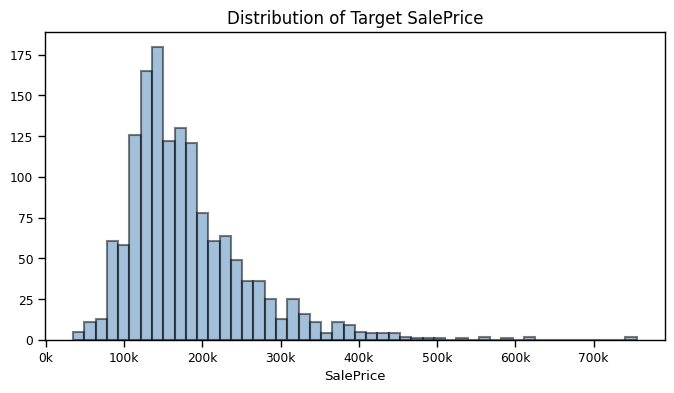

In [8]:
plt.figure(figsize=(8, 4))

plt.hist(houses['SalePrice'], bins=50, edgecolor='black', linewidth=1.5, color='#4682B4', alpha=0.5);
plt.xlabel('SalePrice')
plt.title("Distribution of Target SalePrice", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

plt.show()

# Preparation

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X = houses[features]
y = houses['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=RANDOM_STATE)

preprocessing_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())                  # Scale numeric features
])

X_train_scaled = preprocessing_pipeline.fit_transform(X_train)
X_test_scaled = preprocessing_pipeline.transform(X_test)

In [10]:
y_test.index

Index([ 892, 1105,  413,  522, 1036,  614,  218, 1160,  649,  887,
       ...
        989,  677,  478, 1271, 1410,  479, 1361,  802,  651,  722],
      dtype='int64', length=292)

# Modeling

In [11]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # Required optimization metric for this competition.
    random_state=RANDOM_STATE,
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=2.0,
    early_stopping_rounds=50
)

In [12]:
kf = KFold(n_splits=5, 
           shuffle=True, 
           random_state=RANDOM_STATE)

# Track RMSE per fold.
train_rmse_per_fold = []
val_rmse_per_fold = []

# Track predictions per fold.
train_predictions = []
val_predictions = []

# KFold Cross-Validation.
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled)):
    X_train_cv, X_val_cv = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_train_cv, y_train_cv, eval_set=[(X_val_cv, y_val_cv)], verbose=False)
    
    # Predict on training and validation.
    y_train_pred = xgb_model.predict(X_train_cv)
    y_val_pred = xgb_model.predict(X_val_cv)
    
    # Track predictions.
    train_predictions.append(y_train_pred)
    val_predictions.append(y_val_pred)
    
    # Calculate RMSE.
    train_rmse = np.sqrt(mean_squared_error(y_train_cv, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_cv, y_val_pred))
    
    # Track RMSE.
    train_rmse_per_fold.append(train_rmse)
    val_rmse_per_fold.append(val_rmse)
    
    print(f"Fold {fold+1} -> Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

Fold 1 -> Train RMSE: 247.7984, Validation RMSE: 5971.1700
Fold 2 -> Train RMSE: 298.0933, Validation RMSE: 5945.7664
Fold 3 -> Train RMSE: 182.8531, Validation RMSE: 11932.0777
Fold 4 -> Train RMSE: 250.6029, Validation RMSE: 5936.7442
Fold 5 -> Train RMSE: 273.3152, Validation RMSE: 5106.8196


In [13]:
train_mu, train_sd = np.mean(train_rmse_per_fold), np.std(train_rmse_per_fold)
val_mu, val_sd = np.mean(val_rmse_per_fold), np.std(val_rmse_per_fold)
print(f"Training   RMSE: {train_mu:>7.2f} +- {train_sd:>7.2f}")
print(f"Validation RMSE: {val_mu:>7.2f} +- {val_sd:>7.2f}")

Training   RMSE:  250.53 +-   38.39
Validation RMSE: 6978.52 +- 2498.30


In [14]:
train_predictions = np.concatenate(train_predictions)
val_predictions = np.concatenate(val_predictions)

In [15]:
# Evaluate on test set.
y_test_pred = xgb_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 9586.7193


In [16]:
train_predictions_clean = np.where(np.isinf(train_predictions), np.nan, train_predictions)
val_predictions_clean = np.where(np.isinf(val_predictions), np.nan, val_predictions)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


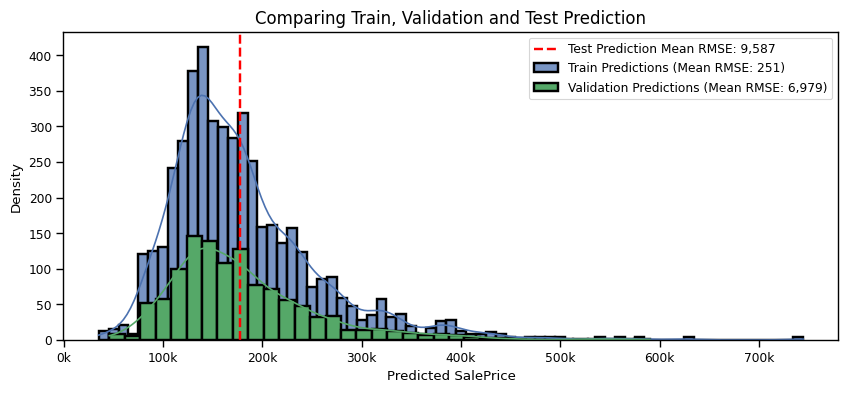

Fold 1 -> Train RMSE: 247.7984, Validation RMSE: 5971.1700
Fold 2 -> Train RMSE: 298.0933, Validation RMSE: 5945.7664
Fold 3 -> Train RMSE: 182.8531, Validation RMSE: 11932.0777
Fold 4 -> Train RMSE: 250.6029, Validation RMSE: 5936.7442
Fold 5 -> Train RMSE: 273.3152, Validation RMSE: 5106.8196


In [17]:
# --------------------------------------------------------- #
# Confidence Intervals for Train and Validation Predictions #
# --------------------------------------------------------- #

plt.figure(figsize=(10, 4))

sns.histplot(train_predictions_clean, kde=True, color="#4C72B0", linewidth=1.75, label=f"Train Predictions (Mean RMSE: {train_mu:,.0f})", alpha=0.75, fill=True)
sns.histplot(val_predictions_clean, kde=True, color="#55A868", linewidth=1.75, label=f"Validation Predictions (Mean RMSE: {val_mu:,.0f})", alpha=1.0, fill=True)

plt.axvline(np.mean(y_test_pred), color="red", linestyle="--", linewidth=1.75, label=f"Test Prediction Mean RMSE: {test_rmse:,.0f}")

plt.title("Comparing Train, Validation and Test Prediction", fontsize=12)
plt.xlabel("Predicted SalePrice")
plt.ylabel("Density")
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

plt.show()

# Display Train/Validation RMSE per fold.
for i, (train_rmse, val_rmse) in enumerate(zip(train_rmse_per_fold, val_rmse_per_fold), 1):
    print(f"Fold {i} -> Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")

In [18]:
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

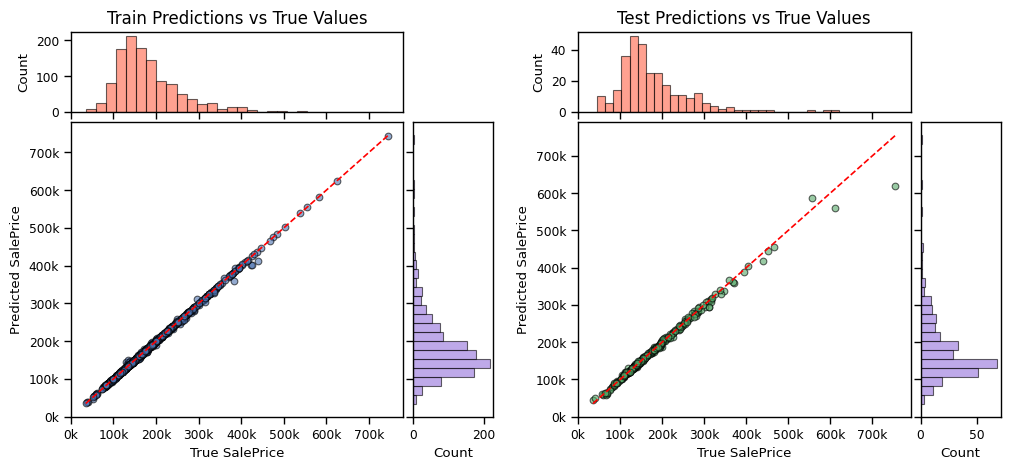

In [19]:
def plot_with_histograms(y_train, y_pred_train, y_test, y_pred_test):
    """Plots train and test predictions with histograms on the right and top."""
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- Train Predictions vs True Values ---
    ax = axes[0]
    ax.scatter(y_train, y_pred_train, color="#4C72B0", alpha=0.6, edgecolor='black')
    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], '--', color='red')
    ax.set_xlabel("True SalePrice")
    ax.set_ylabel("Predicted SalePrice")

    # --- Test Predictions vs True Values ---
    ax = axes[1]
    ax.scatter(y_test, y_pred_test, color="#55A868", alpha=0.6, edgecolor='black')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
    ax.set_xlabel("True SalePrice")
    ax.set_ylabel("Predicted SalePrice")

    for ax in axes:
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))

    for i, (ax, (y_true, y_pred)) in enumerate(zip(axes, [(y_train, y_pred_train), (y_test, y_pred_test)])):
        divider = make_axes_locatable(ax)
        
        ax_histx = divider.append_axes("top", 0.8, pad=0.1, sharex=ax)
        ax_histx.hist(y_pred, bins=30, color='#FF6347', alpha=0.6, edgecolor='black')
        ax_histx.set_ylabel('Count')
        ax_histx.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
        
        ax_histy = divider.append_axes("right", 0.8, pad=0.1, sharey=ax)
        ax_histy.hist(y_true, bins=30, color='#9370DB', alpha=0.6, orientation='horizontal', edgecolor='black')
        ax_histy.set_xlabel('Count')
        ax_histy.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{int(y/1_000)}k'))
        
        if i == 0: 
            ax_histx.set_title('Train Predictions vs True Values', fontsize=12)
        if i == 1:
            ax_histx.set_title('Test Predictions vs True Values', fontsize=12)
        
        plt.setp(ax_histx.get_xticklabels(), visible=False)
        plt.setp(ax_histy.get_yticklabels(), visible=False)


plot_with_histograms(y_train, y_pred_train, y_test, y_pred_test)

Let's take a look at the spread of errors. 

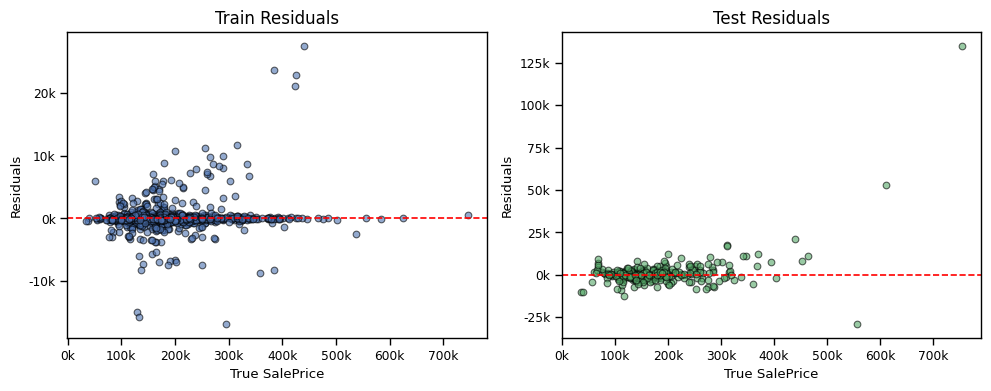

In [20]:
def plot_residuals(y_true_train, y_pred_train, y_true_test, y_pred_test):
    residuals_train = y_true_train - y_pred_train
    residuals_test = y_true_test - y_pred_test

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Train Residuals ---
    axes[0].scatter(y_true_train, residuals_train, color="#4C72B0", edgecolor='black', alpha=0.6)
    axes[0].axhline(0, linestyle='--', color='red')
    axes[0].set_title("Train Residuals", fontsize=12)
    axes[0].set_xlabel("True SalePrice")
    axes[0].set_ylabel("Residuals")

    # --- Test Residuals ---
    axes[1].scatter(y_true_test, residuals_test, color="#55A868", edgecolor='black', alpha=0.6)
    axes[1].axhline(0, linestyle='--', color='red')
    axes[1].set_title("Test Residuals", fontsize=12)
    axes[1].set_xlabel("True SalePrice")
    axes[1].set_ylabel("Residuals")
    
    axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
    axes[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))    
    axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))
    axes[1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1_000)}k'))        

    plt.tight_layout()
    plt.show()
    
plot_residuals(y_train, y_pred_train, y_test, y_pred_test)

# Submission

In [21]:
test_ids = houses.iloc[y_test.index]['Id']

submission_df = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

submission_df.to_csv('submission.csv', index=False)
print(f"Submission file '{filename}' created successfully!")
submission_df

Submission file 'test.csv' created successfully!


,Id,SalePrice
892,893,150877.656250
1105,1106,327954.687500
413,414,117011.257812
522,523,159494.578125
1036,1037,313634.718750
...,...,...
479,480,89324.578125
1361,1362,254782.625000
802,803,187959.625000
651,652,111466.359375


---


💚 Thank you for reading 💚

If you have any questions or feedback, feel free to leave a comment 🤔

This notebook is __still in progress__.

Please __UPVOTE__ if you enjoyed this notebook 🙏